In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from rules import *
import warnings; warnings.simplefilter('ignore')

def get_kendall(x, c1, c2):
    return pd.DataFrame([x[c1],x[c2]]).T.corr(method='kendall')[1].values[0]


# This is a toy example for the experiment 2

In [2]:
# Initialize your experiments
METHOD = 'UM10'
N_PROFILES = 1

In [3]:
results = []


for profile in range(N_PROFILES):
    
    print("Running profile: ", profile)

    for number_issues in range(3,6):

        for number_agents in [100]:
        
            individuals = []
            all_rankings = using_preflib(number_issues, number_agents+1, type_=METHOD)
            for perc_rows in np.arange(0.10, 1.05, 0.01):

                total_rows = calculate_number_of_rows_for_complete_information(number_issues,2)
                number_rows = math.ceil(total_rows * perc_rows)+1
                
                output = data_transform_with_pairwise(individuals, 
                                                      all_rankings, 
                                     number_individuals=number_agents, 
                                     number_proposals=number_issues, 
                                     number_rows=number_rows, 
                                     number_preferences=2)

                data = pd.DataFrame(output)
                data.columns = ["uuid", "option_a", "option_b", "selected"]
                data["id"] = range(1, data.shape[0] + 1)
                data["option_a"] = data["option_a"].astype(int)
                data["option_b"] = data["option_b"].astype(int)
                data["selected"] = data["selected"].astype(int)
                data["option_a_sorted"] = data[["option_a", "option_b"]].min(axis=1).astype(int)
                data["option_b_sorted"] = data[["option_a", "option_b"]].max(axis=1).astype(int)
                data["card_id"] = data["option_a_sorted"].astype(str) + "_" + data["option_b_sorted"].astype(str)
                a = data[["option_a", "option_b", "selected"]].values
                data["option_source"] = np.where(a[:, 1] == a[:, 2], a[:, 0], a[:, 1])
                data["option_target"] = np.where(a[:, 0] == a[:, 2], a[:, 0], a[:, 1])

                df_win_rate = bootstrap4(data, win_rate, iterations=1, 
                                     aggregate=False, rank=True, rank_column="rank")
                ranked_win_rate = list(df_win_rate.sort_values(by='value', ascending=False)['id'].values)
    
                df_copeland = bootstrap4(data, copeland, iterations=1, 
                                         aggregate=False, rank=True, rank_column="rank")
                ranked_copeland = list(df_copeland.sort_values(by='value', ascending=False)['id'].values)

                df_divisiveness_win_rate = bootstrap4(data, divisiveness, iterations=1, 
                                             aggregate=False, rank=True, rank_column="rank")
                ranked_divisiveness_win_rate = list(df_divisiveness_win_rate.sort_values(by='value', ascending=False)['id'].values)


                df_divisiveness_copeland = bootstrap4(data, divisiveness_copeland, iterations=1, 
                                             aggregate=False, rank=True, rank_column="rank")
                ranked_divisiveness_copeland = list(df_divisiveness_copeland.sort_values(by='value', ascending=False)['id'].values)

                df_std = standard_deviation_rankings(all_rankings)
                ranked_std = list(df_std.sort_values(by='value', ascending=False)['id'].values)

                results.append([perc_rows,
                                number_rows,
                                number_issues, 
                                number_agents,
                                profile,
                                ranked_win_rate,\
                                ranked_copeland,\
                                ranked_std,\
                                ranked_divisiveness_win_rate,\
                                ranked_divisiveness_copeland
                ])

    plot = pd.DataFrame(results, 
                        columns=['perc_rows',
                                 'number_rows',
                                 'number_issues',
                                 'number_agents',
                                 'profile',\
                                 'RANK(WR)',
                                 'RANK(COP)',
                                 'RANK(STD)',
                                 'RANK(DIV(WR))',
                                 'RANK(DIV(COP))'])
    plot.to_csv("data/results_incomplete_method_%s_profile_%s.csv"%(METHOD,N_PROFILES), index=False)


Running profile:  0


100%|██████████| 6/6 [00:00<00:00, 146.06it/s]


100%|██████████| 12/12 [00:00<00:00, 156.36it/s]


100%|██████████| 20/20 [00:00<00:00, 168.59it/s]


100%|██████████| 20/20 [00:00<00:00, 149.37it/s]


In [4]:
df = pd.read_csv("data/results_incomplete_method_%s_profile_%s.csv"%(METHOD,N_PROFILES))
df['RANK(WR)'] = df['RANK(WR)'].apply(lambda x: eval(x))
df['RANK(STD)'] = df['RANK(STD)'].apply(lambda x: eval(x))
df['RANK(COP)'] = df['RANK(COP)'].apply(lambda x: eval(x))
df['RANK(DIV(WR))'] = df['RANK(DIV(WR))'].apply(lambda x: eval(x))
df['RANK(DIV(COP))'] = df['RANK(DIV(COP))'].apply(lambda x: eval(x))

In [5]:
df['KT(WR,STD)'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(STD)'), axis=1)
df['KT(WR,COP)'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(COP)'), axis=1)
df['KT(WR,RANK(DIV(WR)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(DIV(WR))'), axis=1)
df['KT(WR,RANK(DIV(COP)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(WR)', c2='RANK(DIV(COP))'), axis=1)
df['KT(RANK(DIV(WR)),STD)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(WR))', c2='RANK(STD)'), axis=1)
df['KT(RANK(DIV(WR)),COP)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(WR))', c2='RANK(COP)'), axis=1)
df['KT(RANK(DIV(WR)),RANK(DIV(COP)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(WR))', c2='RANK(DIV(COP))'), axis=1)
df['KT(RANK(DIV(COP)),STD)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(COP))', c2='RANK(STD)'), axis=1)
df['KT(RANK(DIV(COP)),COP)'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(COP))', c2='RANK(COP)'), axis=1)
df['KT(RANK(DIV(COP)),RANK(DIV(WR)))'] = df.apply(lambda x: get_kendall(x, c1='RANK(DIV(COP))', c2='RANK(DIV(WR))'), axis=1)

In [6]:
df.head()

,perc_rows,number_rows,number_issues,number_agents,profile,RANK(WR),RANK(COP),RANK(STD),RANK(DIV(WR)),RANK(DIV(COP)),"KT(WR,STD)","KT(WR,COP)","KT(WR,RANK(DIV(WR)))","KT(WR,RANK(DIV(COP)))","KT(RANK(DIV(WR)),STD)","KT(RANK(DIV(WR)),COP)","KT(RANK(DIV(WR)),RANK(DIV(COP)))","KT(RANK(DIV(COP)),STD)","KT(RANK(DIV(COP)),COP)","KT(RANK(DIV(COP)),RANK(DIV(WR)))"
0,0.10,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[0, 1, 2]","[0, 1, 2]",-0.333333,1.0,1.000000,1.000000,-0.333333,1.000000,1.000000,-0.333333,1.000000,1.000000
1,0.11,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 1, 0]","[0, 1, 2]",-0.333333,1.0,-1.000000,1.000000,0.333333,-1.000000,-1.000000,-0.333333,1.000000,-1.000000
2,0.12,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 1, 0]","[0, 2, 1]",-0.333333,1.0,-1.000000,0.333333,0.333333,-1.000000,-0.333333,-1.000000,0.333333,-0.333333
3,0.13,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 1, 0]","[2, 0, 1]",-0.333333,1.0,-1.000000,-0.333333,0.333333,-1.000000,0.333333,1.000000,-0.333333,0.333333
4,0.14,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 0, 1]","[2, 0, 1]",-0.333333,1.0,-0.333333,-0.333333,1.000000,-0.333333,1.000000,1.000000,-0.333333,1.000000


In [7]:
df['Robusteness(WR)'] = -1
df['Robusteness(COP)'] = -1
df['Robusteness(DIV,WR)'] = -1
df['Robusteness(DIV,COP)'] = -1

for each_row in df.iterrows():
    
    rank_wr = df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
          ].sort_values(by='perc_rows').tail(1)['RANK(WR)'].values[0]
    
    
    rank_wr1 = float(df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
            & (df['perc_rows']<=each_row[1]['perc_rows'])
          ].sort_values(by='perc_rows')['Robusteness(WR)'].max())
    
    kt_wr = float(pd.DataFrame([each_row[1]['RANK(WR)'], rank_wr]).T.corr(method='kendall')[1].values[0])
    
    if kt_wr < rank_wr1:
        kt_wr = rank_wr1
    df.loc[df.index == each_row[0], 'Robusteness(WR)'] = kt_wr
    
    rank_cop = df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
          ].sort_values(by='perc_rows').tail(1)['RANK(COP)'].values[0]
    
    rank_cop1 = float(df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
            & (df['perc_rows']<=each_row[1]['perc_rows'])
          ].sort_values(by='perc_rows')['Robusteness(COP)'].max())
    
    kt_wr = float(pd.DataFrame([each_row[1]['RANK(COP)'], rank_cop]).T.corr(method='kendall')[1].values[0])
    
    if kt_wr < rank_cop1:
        kt_wr = rank_cop1
    df.loc[df.index == each_row[0], 'Robusteness(COP)'] = kt_wr
    
    
    
    rank_div_wr = df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
          ].sort_values(by='perc_rows').tail(1)['RANK(DIV(WR))'].values[0]
    
    rank_div_cop =df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
          ].sort_values(by='perc_rows').tail(1)['RANK(DIV(COP))'].values[0]
    
    rank_div_wr1 = float(df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
            & (df['perc_rows']<=each_row[1]['perc_rows'])
          ].sort_values(by='perc_rows')['Robusteness(DIV,WR)'].max())
        
    rank_div_cop1 = float(df[(df['number_issues']==each_row[1]['number_issues'])
          & (df['number_agents']==each_row[1]['number_agents'])
          & (df['profile']==each_row[1]['profile'])
            & (df['perc_rows']<=each_row[1]['perc_rows'])
          ].sort_values(by='perc_rows')['Robusteness(DIV,COP)'].max())

        
    kt_wr = float(pd.DataFrame([each_row[1]['RANK(DIV(WR))'], rank_div_wr]).T.corr(method='kendall')[1].values[0])
    
    if kt_wr < rank_div_wr1:
        kt_wr = rank_div_wr1
    df.loc[df.index == each_row[0], 'Robusteness(DIV,WR)'] = kt_wr
    
    kt_cop = float(pd.DataFrame([each_row[1]['RANK(DIV(COP))'], rank_div_cop]).T.corr(method='kendall')[1].values[0])
    
    if kt_cop < rank_div_cop1:
        kt_cop = rank_div_cop1
    df.loc[df.index ==each_row[0], 'Robusteness(DIV,COP)'] = kt_cop
    

In [8]:
df.to_csv("data/results_incomplete_method_%s_profile_%s_kendall.csv"%(METHOD,N_PROFILES), index=False)

In [9]:
df['Robusteness(WR)'] = df['Robusteness(WR)'].astype(float)
df['Robusteness(COP)'] = df['Robusteness(COP)'].astype(float)
df['Robusteness(DIV,WR)'] = df['Robusteness(DIV,WR)'].astype(float)
df['Robusteness(DIV,COP)'] = df['Robusteness(DIV,COP)'].astype(float)
df['perc_rows'] = df['perc_rows'].astype(float)*100

In [10]:
df.head()

,perc_rows,number_rows,number_issues,number_agents,profile,RANK(WR),RANK(COP),RANK(STD),RANK(DIV(WR)),RANK(DIV(COP)),...,"KT(RANK(DIV(WR)),STD)","KT(RANK(DIV(WR)),COP)","KT(RANK(DIV(WR)),RANK(DIV(COP)))","KT(RANK(DIV(COP)),STD)","KT(RANK(DIV(COP)),COP)","KT(RANK(DIV(COP)),RANK(DIV(WR)))",Robusteness(WR),Robusteness(COP),"Robusteness(DIV,WR)","Robusteness(DIV,COP)"
0,10.0,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[0, 1, 2]","[0, 1, 2]",...,-0.333333,1.000000,1.000000,-0.333333,1.000000,1.000000,1.0,1.0,-1.0,-0.333333
1,11.0,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 1, 0]","[0, 1, 2]",...,0.333333,-1.000000,-1.000000,-0.333333,1.000000,-1.000000,1.0,1.0,1.0,-0.333333
2,12.0,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 1, 0]","[0, 2, 1]",...,0.333333,-1.000000,-0.333333,-1.000000,0.333333,-0.333333,1.0,1.0,1.0,-0.333333
3,13.0,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 1, 0]","[2, 0, 1]",...,0.333333,-1.000000,0.333333,1.000000,-0.333333,0.333333,1.0,1.0,1.0,1.000000
4,14.0,2,3,100,0,"[0, 1, 2]","[0, 1, 2]","[2, 0, 1]","[2, 0, 1]","[2, 0, 1]",...,1.000000,-0.333333,1.000000,1.000000,-0.333333,1.000000,1.0,1.0,1.0,1.000000


In [11]:
subp = df.melt(id_vars=['perc_rows','number_issues','number_agents','profile'],\
                 value_vars=["Robusteness(DIV,WR)",
                             "Robusteness(DIV,COP)",
                            "KT(RANK(DIV(COP)),RANK(DIV(WR)))"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


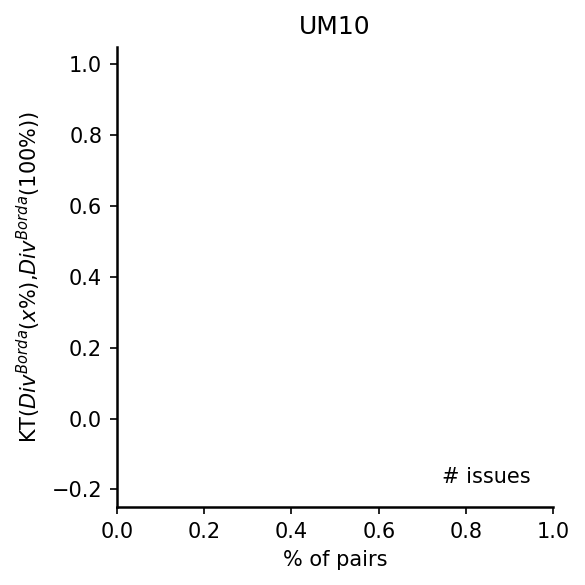

In [12]:
#Figure1: kendall-tau on the vertical axis, 
# number of individuals on horiz axis (fix number of items=20)
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4), dpi=150)

subp['size'] = 1500
g = sns.lineplot(data=subp[(subp['number_agents'].isin([10])) & 
                           (subp['variable'].isin(["Robusteness(DIV,WR)"])) & 
                          (subp['number_issues'].isin([4,6,8,10,14,18]))].dropna(), \
             x='perc_rows', y='value',\
                 hue='number_issues',
             linewidth=2, 
                 style='number_issues',\
                 markers = True, 
                 alpha=0.9, palette='Dark2', legend=True,
              ax=ax)
leg = g.legend(title="# issues", frameon=False, fontsize=7, ncol=3, loc='lower right')
leg.get_title().set_position((-10, 0))
for line in leg.get_lines():
    line.set_linewidth(1.4)
    
# for dots in g.collections:
#     dots.set_alpha(1)
#     dots.set_s(1500)


ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim(-0.25,1.05)
plt.title("UM10")
# import matplotlib.ticker as mticker
# ax.xaxis.set_major_locator(mticker.MultipleLocator(100))
ax.set_ylabel("KT($\mathit{Div}^\mathit{Borda}(x\%)$,$\mathit{Div}^\mathit{Borda}(100\%)$)")
ax.set_xlabel("% of pairs")
plt.tight_layout()
plt.savefig("figures/figure_experiment_2.pdf")